Install essential packages

In [1]:
!conda install -y pytorch torchvision cudatoolkit=10.1 -c pytorch
!pip install transformers

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import shuffle # shuffle samples after concat'ing DataFrames
from transformers import BertTokenizer, BertForSequenceClassification
import torch
# torch submodules allow us to tweak characteristics of the model
# hidden layers, activation functions, etc.
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt # plot loss
from sklearn.model_selection import train_test_split

Mount Google drive to access training data.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read each training .tsv into a DataFrame and inspect data.

In [4]:
#path_to_training_data = 'C:/Users/User/Notebooks/BERT/Training Data'
path_to_training_data = '/content/drive/MyDrive/School/ITS 490 Research Project/Data/Training Data'

human_real_news = pd.read_csv(path_to_training_data+'/Kaggle-True-Training.tsv', delimiter='\t')
human_fake_news = pd.read_csv(path_to_training_data+'/Kaggle-Fake-Training.tsv', delimiter='\t')
davinci_real_news = pd.read_csv(path_to_training_data+'/Davinci-True-Training.tsv', delimiter='\t')
davinci_fake_news = pd.read_csv(path_to_training_data+'/Davinci-Fake-Training.tsv', delimiter='\t')
chatgpt_real_news = pd.read_csv(path_to_training_data+'/ChatGPT-True-Training.tsv', delimiter='\t')
chatgpt_fake_news = pd.read_csv(path_to_training_data+'/ChatGPT-Fake-Training.tsv', delimiter='\t')

In [5]:
min_articles = min(len(human_fake_news), len(human_real_news), len(davinci_real_news),
                   len(davinci_fake_news), len(chatgpt_fake_news), len(chatgpt_fake_news))

human_fake_news = human_fake_news[:min_articles]
human_real_news = human_real_news[:min_articles]
davinci_real_news = davinci_real_news[:min_articles]
davinci_fake_news = davinci_fake_news[:min_articles]
chatgpt_real_news = chatgpt_real_news[:min_articles]
chatgpt_fake_news = chatgpt_fake_news[:min_articles]

print(len(human_fake_news))
print(len(davinci_real_news))
print(len(human_fake_news))
print(len(human_real_news))
print(len(chatgpt_real_news))
print(len(chatgpt_fake_news))


1199
1199
1199
1199
1199
1199


Then add a 'label' column to each DF.

In [6]:
davinci_real_news['is_fake'] = False
davinci_fake_news['is_fake'] = True
human_fake_news['is_fake'] = True
human_real_news['is_fake'] = False
chatgpt_real_news['is_fake'] = False
chatgpt_fake_news['is_fake'] = True

Consolidate dataframes

In [29]:
real_data = pd.concat([davinci_real_news,human_real_news])
real_data = pd.concat([real_data, chatgpt_real_news])
fake_data = pd.concat([davinci_fake_news,human_fake_news])
fake_data = pd.concat([fake_data, chatgpt_fake_news])


data = pd.concat([real_data, fake_data])

# Shuffle the data
data = shuffle(data).reset_index(drop=True)
data = data[['text', 'is_fake']]
data.head()

,text,is_fake
0,Donald Trump is desperate to distract everyone...,True
1,Washington was rocked by yet another staff sha...,True
2,As government responses to the COVID-19 pandem...,False
3,"In recent years, the world has seen a staggeri...",True
4,NaN,False


In [30]:
len(data)

7194

Split the data into three sets: training, validation and testing

In [31]:
train_data, validate_data, test_data = np.split(data.sample(frac=1), [int(1*len(data)), int(.9999*len(data))])

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# delete old dataframes
#del real_data
#del fake_data
#del validate_data

print("Size of training set: {}".format(len(train_data)))
print("Size of testing set: {}".format(len(test_data)))

Size of training set: 7194
Size of testing set: 1


Define the hardware in which the code will run on.

Instantiate a BERT model and tokenizer.

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [34]:
print(device)

cuda


Now we freeze all the pretrained portion of the network and add a new section at the end of the network.

This is done because the model has already been trained on a large amount of data. We can leverage the performance of the pretrained model to improve the the new model.

Then we add our new layers and alternate between different activation functions. This is a recent technique that I've learned about. It helps prevent the model from memorizing the training data too closely and encourages the model to learn more features of the data.

In [36]:
# Freeze the pre trained parameters
for param in model.parameters():
    param.requires_grad = False

# Add three new layers at the end of the network
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

model = model.to(device)

Below, we define a criterion which refers to a pre-defined loss function such as cross-entropy (classification) or MSE (regression)

We define an optimzer using SGD and set learning rate to 0.01 initally. We will have to play with this to see how it effects metrics.

NOTE: Stochastic Gradient Descent (SGD) is one of the 3 main steps in the deep learning training process. The cycle is: feed forward --> SGD --> backwards propogation (back prop)

In [37]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

Here we define a function to do preprocessing on each text. This includes splitting the text into words and tokenizing them.  

In [38]:
def preprocess_text(text):
    parts = []

    text_len = len(text.split(' '))
    delta = 150
    max_parts = 4
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

# Training

In [39]:
# monitor loss
print_every = 300
total_loss = 0
all_losses = []

CUDA_LAUNCH_BLOCKING=1

model.train()

for idx, row in train_data.iterrows():
    text_parts = preprocess_text(str(row['text']))
    label = torch.tensor([row['is_fake']]).long().to(device)

    # zero out the gradients
    optimizer.zero_grad()

    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                # print(input.shape)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

    # overall_output /= len(text_parts)
    overall_output = F.softmax(overall_output[0], dim=-1)

    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)

    #print(overall_output, label)

    loss = criterion(overall_output, label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    # display loss
    if idx % print_every == 0 and idx > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(idx, len(train_data), average_loss))
        all_losses.append(average_loss)
        total_loss = 0

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


300/7194. Average loss: 0.24650757347544033
600/7194. Average loss: 0.24380644908795754
900/7194. Average loss: 0.23770987338076036
1200/7194. Average loss: 0.21641733336262406
1500/7194. Average loss: 0.22646442857570948
1800/7194. Average loss: 0.20854997737643619
2100/7194. Average loss: 0.21888676818149785
2400/7194. Average loss: 0.21487009181330602
2700/7194. Average loss: 0.1925675916338029
3000/7194. Average loss: 0.20501956490576656
3300/7194. Average loss: 0.20046241642635626
3600/7194. Average loss: 0.18812676830120229
3900/7194. Average loss: 0.18801431421093487
4200/7194. Average loss: 0.203205950158687
4500/7194. Average loss: 0.18125528036480926
4800/7194. Average loss: 0.20675324963774377
5100/7194. Average loss: 0.20053186556731817
5400/7194. Average loss: 0.1657052485444971
5700/7194. Average loss: 0.19209250069378564
6000/7194. Average loss: 0.17161715257161025
6300/7194. Average loss: 0.17866172890969514
6600/7194. Average loss: 0.1799460070588005
6900/7194. Average

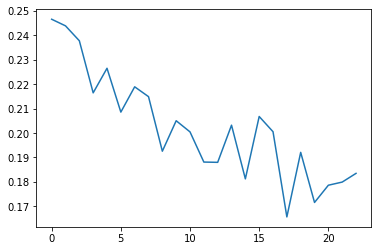

In [40]:
torch.save(model.state_dict(), "model_after_train3.pt")

%matplotlib inline
plt.plot(all_losses)

## **Test data**

In [41]:
total = len(test_data)
correct = 0
model.eval()
with torch.no_grad():
    for idx, row in test_data.iterrows():
        text_parts = preprocess_text(str(row['text']))
        label = torch.tensor([row['is_fake']]).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device)
        try:
            for part in text_parts:
                if len(part) > 0:
                    overall_output += model(part.reshape(1, -1))[0]
        except RuntimeError as e:
            print(e)
            continue
            
        overall_output = F.softmax(overall_output[0], dim=-1)
        result = overall_output.max(0)[1].float().item()
 
        if result == label.item():
            correct += 1
            
        if idx % print_every == 0 and idx > 0:
            print("{}/{}. Current accuracy: {}".format(idx, total, correct / idx))
            
print("Accuracy on test data: {}".format(correct / total))
            

Accuracy on test data: 0.0


Softmax is an activation function. It changes the values of the output vector to values between 0 and 1, that when summed equals 1. Which means that whichever value is greatest is the class. - probability distribution

In [42]:
def predict(text):
    text_parts = preprocess_text(text)
    overall_output = torch.zeros((1,2)).to(device)
    try:
        for part in text_parts:
            if len(part) > 0:
                overall_output += model(part.reshape(1, -1))[0]
    except RuntimeError:
        print("GPU out of memory, skipping this text.")

    overall_output = F.softmax(overall_output[0], dim=-1)
    
    # result is equal to the maximum probability for each class    
    value, result = overall_output.max(0)

    label = "fake"
    if result.item() == 0:
        label = "real"
        return True
    else:
      return False

    print("{} at {}%".format(label, value.item() * 100))

In [43]:
fake1 = """
Americans to fund killing babies in abortion that she has been caught trying to add taxpayer financing of abortions to the bill to combat the Coronavirus and provide economic stimulus to the nation as it deals with the COVD-19 outbreak.
Nancy Pelosi has a long history of promoting abortion and her first act after becoming Speaker in 2019 was pushing legislation to use tax money for abortions. So it’s no surprise she is trying to exploit the Coronavirus pandemic to push abortion funding again.
As The Daily Caller reports: House Speaker Nancy Pelosi sought to include a potential way to guarantee federal funding for abortion into the coronavirus economic stimulus plan, according to multiple senior White House officials.
Speaking to the Daily Caller, those officials alleged that while negotiating the stimulus with U.S. Treasury Secretary Steve Mnuchin, Pelosi tried to lobby for “several” provisions that stalled bipartisan commitment to the effort. One was a mandate for up to $1 billion to reimburse laboratory claims, which White House officials say would set a precedent of health spending without protections outlined in the Hyde Amendment.
LifeNews depends on the support of readers like you to combat the pro-abortion media. Please donate now.
“A New mandatory funding stream that does not have Hyde protections would be unprecedented,” one White House official explained. “Under the guise of protecting people, Speaker Pelosi is working to make sure taxpayer dollars are spent covering abortion—which is not only backwards, but goes against historical norms.”
A second White House official referred to the provision as a “slush fund” and yet another questioned “what the Hyde Amendment and abortion have to do with protecting Americans from coronavirus?”
Americans should insist to their members of Congress that we need a clean bill that provides aggressive action to help patients and spur the economy. Killing babies with our tax dollars is not the answer to the coronavirus and the situation should not be exploited for political gain.
"""

true1 = """
Price spikes, however, would cause demand to wither and some expensive avocados might be leftover, and stores might try to ration avocados, he added.
"Exactly what the retail strategy would be in this case, I’m not sure. But we would have vastly fewer avocados," Sumner said.
Just how fast avocados would disappear, if at all, would depend on whether the Trump administration enacts a full or partial border closure. White House economic adviser Larry Kudlow told CNBC he’s looking for ways to keep some commerce flowing.
"We are looking at different options, particularly if you can keep those freight lanes, the truck lanes, open," he said this week.  
Ben Holtz owns Rocky H Ranch, a 70-acre family-run avocado farm in northern San Diego County. He agreed avocados would run out within weeks.
"Mexico is the big player today. California is not. You shut down the border and California can’t produce to meet the demand," Holtz said. "There will be people without their guacamole."
While Mexico’s avocado harvest is year-round, California’s is limited to April through July. Growers in the state have picked only about 3 percent of what’s expected to be a much smaller crop of about 175 million pounds this year, Holtz said. A heat wave last summer reduced the crop size.
California’s avocado harvest has averaged approximately 300 million pounds in recent years, according to data from the California Avocado Commission. By contrast, the U.S. has imported more than 1.5 billion pounds of avocados from Mexico annually. Representatives from the commission did not respond to requests for this article.
Altogether, the U.S. received 43 percent of its fruit and vegetable imports from Mexico in 2016, according to the U.S. Department of Agriculture.
Also affecting this year’s avocado supply, a California avocado company in March recalled shipments to six states last month after fears the fruit might be contaminated with a bacterium that can cause health risks.
Until the early 2000s, California was the nation’s leading supplier of avocados, Holtz said. Mexico gradually overtook the state and now dominates sales in the U.S.
"It’s a very big possibility," Holtz said of avocado shortages. "Three weeks would dry up the Mexican inventory. California alone consumes more avocados than are grown in our state. Cold storage supply chain is basically three weeks or less of inventory. Most of the time it’s seven days."
A spokeswoman for the California Restaurant Association said "we haven’t heard concerns from restaurants, it doesn’t mean they aren’t worried." A national grocers association said it will "continue to closely monitor any developments" at the border, but did not have information about the potential impact on avocados.
"""

sample = """
The renewable energy industry has been growing rapidly as companies seek to reduce their environmental impact. However, there are real questions as to whether renewable energy is as efficient and cost-effective as its proponents claim.

Recent research has revealed that renewables are not as reliable as other sources of energy and can be costly to maintain. Even when the sun is shining, solar panels can be blocked by trees, leading to lost electricity and increased costs. In addition, renewable energy production is dependent on weather patterns, which can be unpredictable and lead to uncertain supply.

Furthermore, the energy generated by renewables is inconsistent, requiring energy storage to ensure a steady supply. This adds further costs to an already expensive system. And while wind and solar are intermittent sources of energy, they are not always available when the demand is high.

Additionally, the cost of installing renewable energy systems is often prohibitive. Building and maintaining a wind turbine, for example, can cost millions of dollars. This makes them expensive for individual consumers and for businesses that require large amounts of energy.

Despite the increasing popularity of renewable energy sources, the reality is that they are not a viable or cost-effective alternative to traditional energy sources. There simply is not enough energy produced reliably and consistently enough to meet our current energy needs.

The proponents of renewable energy claim that it is the best way to reduce environmental pollution, but the evidence does not back up this claim. Renewables may help to reduce carbon emissions, but the costs and unreliability remain.

In conclusion, the argument that renewable energy is the best alternative for reducing pollution and meeting our energy needs is not supported by the facts. Renewables may have a role to play in the future, but until their costs and reliability can be addressed, they are unlikely to become the primary sources of energy."
"""

predict(fake1)
predict(true1)

list = (fake1, true1, sample)

In [44]:
real_count = 0
fake_count = 0

def multi_article_test(test_data, real_count, fake_count):
  for text in test_data:
    if(predict(text) == True):
      real_count += 1
    else:
      fake_count += 1
  total = real_count + fake_count
  print("Total Predicted = ", total)    
  print("Predicted real = ", real_count)
  print("Predicted fake = ", fake_count)
  print()
  print("Accuracy = ", fake_count/total)

In [45]:
#multi_article_test(test_data.iloc[:, 0], real_count, fake_count)

In [46]:
torch.save(model.state_dict(), 'bertNewsClassifier3_state_dict.pth')
torch.save(model, 'bertNewsClassifier3_model.pth')